In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [17]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

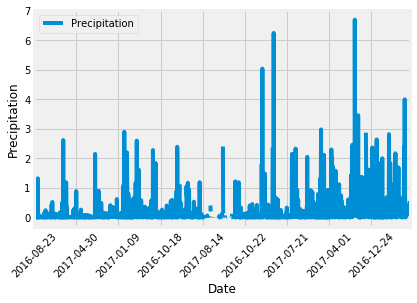

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

first_date = session.query(Measurement.date).order_by(Measurement.date).first()
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date

 
# Calculate the date 1 year ago from the last data point in the database
year_ago = dt.datetime.strptime(last_date,'%Y-%m-%d')-dt.timedelta(days=365)
year_ago

# Perform a query to retrieve the data and precipitation scores
twelve_months_prep =session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date.between('2016-08-23','2017-08-23')).all()

twelve_months_prep
# Save the query results as a Pandas DataFrame and set the index to the date column
prep_df = pd.DataFrame(twelve_months_prep,columns=['Date','Precipitation'])
prep_df.set_index('Date',inplace=True)
# Sort the dataframe by date
prep_df.sort_values(by='Date')
# Use Pandas Plotting with Matplotlib to plot the data
prep_df.plot(x_compat=True)
#plt.tight_layout()
plt.ylabel("Precipitation")
plt.xlabel("Date")
plt.xticks(rotation='45')
plt.show()



![precipitation](Images/precipitation.png)

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prep_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [13]:
# Design a query to show how many stations are available in this dataset?
stations=session.query(Station.id).count()
stations

9

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
final_res=session.query(Measurement.station,func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
final_res
        


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [24]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
active_station = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
    filter(Measurement.station =="USC00519281").all()
active_station


[(54.0, 85.0, 71.66378066378067)]

<function matplotlib.pyplot.show(*args, **kw)>

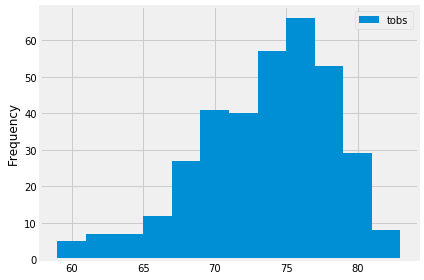

In [39]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
twelve_months_station =session.query(Measurement.station,Measurement.tobs).\
    filter(Measurement.date.between('2016-08-23','2017-08-23')).filter(Measurement.station =="USC00519281").all()
df_tob=pd.DataFrame(twelve_months_station)
df_tob.set_index('station',inplace=True)
df_tob.head()

#plotting 
df_tob.plot.hist(bins=12)
plt.tight_layout()
plt.show



![precipitation](Images/station-histogram.png)

In [40]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [43]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2017-05-31','2017-06-07'))


[(74.0, 77.86, 81.0)]


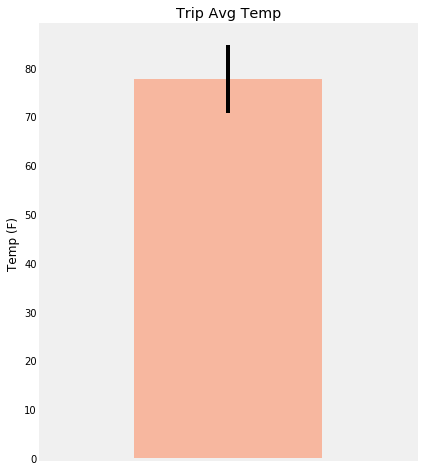

In [58]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip=calc_temps('2017-05-31','2017-06-07')
df_trip=pd.DataFrame(trip,columns=['min temp','Avg Temp','Max Temp'])
avg_temp=df_trip['Avg Temp']
max_min=df_trip.iloc[0]['Max Temp']-df_trip.iloc[0]['min temp']
avg_temp.plot(kind='bar',yerr=max_min,figsize=(6,8),alpha=0.5,color='coral')
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F) ")
plt.xticks([])
plt.grid()
plt.savefig("Trip_Temp_Summary")

In [73]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
last_twelve=session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date.between('2017-05-31','2017-06-07')).all()

start_date = '2017-05-31'
end_date = '2017-06-07'
sel = [Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation,func.sum(Measurement.prcp)]

solution = session.query(*sel).\
    filter(Measurement.station==Station.station).\
    filter(Measurement.date.between(start_date,end_date)).\
    group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()
    
print(solution)

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.85), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.6000000000000001), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.5800000000000001), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.38), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.15), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.04), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]


## Optional Challenge Assignment

In [77]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [79]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-05-31'
end_date = '2017-06-07'
# Use the start and end date to create a range of dates
trip_d = pd.date_range(start_date,end_date,freq='D')

# Stip off the year and save a list of %m-%d strings
trip_m = trip_d.strftime('%m-%d')

# Loop through the list of %m-%d strings and calculate the normals for each date
normal = []
for x in trip_m:
    normal.append(*daily_normals(x))
    
normal

[(68.0, 74.4, 81.0),
 (64.0, 74.6140350877193, 81.0),
 (65.0, 74.4, 81.0),
 (65.0, 74.03448275862068, 80.0),
 (65.0, 73.81818181818181, 81.0),
 (68.0, 74.85454545454546, 81.0),
 (70.0, 75.17543859649123, 80.0),
 (68.0, 75.07142857142857, 81.0)]

In [85]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normal_df = pd.DataFrame(normal,columns = ['t_min','t_avg','t_max'])
normal_df["date"] = trip_d
normal_df.set_index('date',inplace=True)
normal_df

,t_min,t_avg,t_max
date,,,
2017-05-31,68.0,74.400000,81.0
2017-06-01,64.0,74.614035,81.0
2017-06-02,65.0,74.400000,81.0
2017-06-03,65.0,74.034483,80.0
2017-06-04,65.0,73.818182,81.0
2017-06-05,68.0,74.854545,81.0
2017-06-06,70.0,75.175439,80.0
2017-06-07,68.0,75.071429,81.0


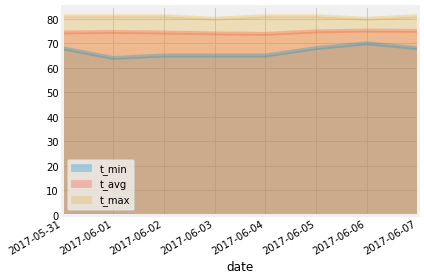

In [92]:
# Plot the daily normals as an area plot with `stacked=False`
normal_df.plot(kind='area',stacked=False,alpha=0.3,x_compat=True)
plt.tight_layout()
